# Kompresja video


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

## Konfiguracja


In [2]:
kat = ".\\"  # katalog z plikami wideo
plik = "clip_1.mp4"  # nazwa pliku
ile = 10  # ile klatek odtworzyc? <0 - calosc
key_frame_counter = 2  # co ktora klatka ma byc kluczowa i nie podlegac kompresji
plot_frames = np.array([30, 45])  # automatycznie wyrysuj wykresy
auto_pause_frames = np.array([25])  # automatycznie zapauzuj dla klatki i wywietl wykres
# subsampling = "4:4:4"  # parametry dla chorma subsamplingu
subsampling = "4:2:2"  # parametry dla chorma subsamplingu
wyswietlaj_kaltki = True  # czy program ma wyswietlac kolejene klatki



## Kompresja i dekompresja


In [3]:
def reconstruct_image(data, A):
    tmp = np.zeros(A)
    cnt = 0
    block = 8
    for i in range(0, A[0], block):
        for j in range(0, int(A[1]), block):
            tmp[i : i + block, j : j + block] = data[cnt] + 128
            cnt = cnt + 1
    return tmp


def dct2(a):
    return scipy.fftpack.dct(
        scipy.fftpack.dct(a.astype(float), axis=0, norm="ortho"), axis=1, norm="ortho"
    )


def idct2(a):
    return scipy.fftpack.idct(
        scipy.fftpack.idct(a.astype(float), axis=0, norm="ortho"), axis=1, norm="ortho"
    )


def eight_coding(A):
    tmp = []
    block = 8
    for i in range(0, A.shape[0], block):
        for j in range(0, A.shape[1], block):
            tmp.append(A[i : i + block, j : j + 8] - 128)
    tmp = np.array(tmp)
    return tmp

def chroma_subsampling(img, J, a, b):
    tmp = []
    if J == 4 and a == 2 and b == 2:
        tmp = img[::, 0::a]
    if J == 4 and a == 4 and b == 4:
        tmp = img[::, ::]
    return tmp


def chroma_resampling(img, J, a, b, shape):
    tmp = []
    if J == 4 and a == 2 and b == 2:
        tmp = np.zeros((shape[0], shape[1]))
        tmp[::, 0::a] = img[::, ::]
        tmp[::, 1::a] = tmp[::, 0::a]
    if J == 4 and a == 4 and b == 4:
        tmp = img[::, ::]
    return tmp


def zigzag(A):
    template = np.array(
        [
            [0, 1, 5, 6, 14, 15, 27, 28],
            [2, 4, 7, 13, 16, 26, 29, 42],
            [3, 8, 12, 17, 25, 30, 41, 43],
            [9, 11, 18, 24, 31, 40, 44, 53],
            [10, 19, 23, 32, 39, 45, 52, 54],
            [20, 22, 33, 38, 46, 51, 55, 60],
            [21, 34, 37, 47, 50, 56, 59, 61],
            [35, 36, 48, 49, 57, 58, 62, 63],
        ]
    )
    if len(A.shape) == 1:
        B = np.zeros((8, 8))
        for r in range(0, 8):
            for c in range(0, 8):
                B[r, c] = A[template[r, c]]
    else:
        B = np.zeros((64,))
        for r in range(0, 8):
            for c in range(0, 8):
                B[template[r, c]] = A[r, c]
    return B

def quantization(data, sign, layer):
    QY = np.array(
        [
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
        ]
    )

    QC = np.array(
        [
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
        ]
    )
    arr = np.zeros(data.shape)
    if layer == "Y":
        if sign == "divide":
            arr = np.round(data / QY).astype(int)
        if sign == "multiply":
            arr = data * QY
    if layer == "Cr":
        if sign == "divide":
            arr = np.round(data / QC).astype(int)
        if sign == "multiply":
            arr = data * QC
    if layer == "Cb":
        if sign == "divide":
            arr = np.round(data / QC).astype(int)
        if sign == "multiply":
            arr = data * QC

    return arr

class data:
    def init(self):
        self.Y = None
        self.Cb = None
        self.Cr = None


def compress(
    Y, Cb, Cr, key_frame_Y, key_frame_Cb, key_frame_Cr, inne_paramerty_do_dopisania=None
):
    J, a, b = list(map(int, subsampling.split(":")))
    # YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb).astype(int)
    # Y = YCrCb[:, :, 0]
    # Cr = YCrCb[:, :, 1]
    # Cb = YCrCb[:, :, 2]

    Cr_subsampled = chroma_subsampling(Cr, J, a, b)
    Cb_subsampled = chroma_subsampling(Cb, J, a, b)
    Cr = Cr_subsampled
    Cb = Cb_subsampled
    Y = eight_coding(Y)
    Cr = eight_coding(Cr)
    Cb = eight_coding(Cb)

    # DCT2
    dct_arr_Y = []
    for block in Y:
        dct_arr_Y.append(dct2(block))
    dct_arr_Y = np.array(dct_arr_Y)
    Y = dct_arr_Y.astype(int)

    dct_arr_Cr = []
    for block in Cr:
        dct_arr_Cr.append(dct2(block))
    dct_arr_Cr = np.array(dct_arr_Cr)
    Cr = dct_arr_Cr.astype(int)

    dct_arr_Cb = []
    for block in Cb:
        dct_arr_Cb.append(dct2(block))
    dct_arr_Cb = np.array(dct_arr_Cb)
    Cb = dct_arr_Cb.astype(int)

    # Quantize
    q_arr_Y = []
    for block in Y:
        q_arr_Y.append(quantization(block, "divide", "Y"))
    q_arr_Y = np.array(q_arr_Y)
    Y = q_arr_Y

    q_arr_Cr = []
    for block in Cr:
        q_arr_Cr.append(quantization(block, "divide", "Cr"))
    q_arr_Cr = np.array(q_arr_Cr)
    Cr = q_arr_Cr

    q_arr_Cb = []
    for block in Cb:
        q_arr_Cb.append(quantization(block, "divide", "Cb"))
    q_arr_Cb = np.array(q_arr_Cb)
    Cb = q_arr_Cb

    # Zigzag
    zzY = []
    for block in Y:
        zzY.append(zigzag(block))
    zzY = np.array(zzY)
    Y = zzY

    zzCr = []
    for block in Cr:
        zzCr.append(zigzag(block))
    zzCr = np.array(zzCr)
    Cr = zzCr

    zzCb = []
    for block in Cb:
        zzCb.append(zigzag(block))
    zzCb = np.array(zzCb)
    Cb = zzCb

    # return Y, Cr, Cb, Cr_subsampled.shape

    
    
    data.Y = Y
    data.Cb = Cb
    data.Cr = Cr
    return data,Cr_subsampled.shape


def decompress(
    data, key_frame_Y, key_frame_Cb, key_frame_Cr, A, shape, inne_paramerty_do_dopisania=None
):
    Y = data.Y
    Cb = data.Cb 
    Cr = data.Cr 
    J, a, b = list(map(int, subsampling.split(":")))

    Y_to_blocks = []
    tmp = []
    for block in Y:
        tmp = zigzag(block)
        Y_to_blocks.append(tmp.reshape(8, 8))
    Y_to_blocks = np.array(Y_to_blocks)
    Y = Y_to_blocks
    tmp = 0

    Cr_to_blocks = []
    for block in Cr:
        tmp = zigzag(block)
        Cr_to_blocks.append(tmp.reshape(8, 8))
    Cr_to_blocks = np.array(Cr_to_blocks)
    Cr = Cr_to_blocks
    tmp = 0

    Cb_to_blocks = []
    for block in Cb:
        tmp = zigzag(block)
        Cb_to_blocks.append(tmp.reshape(8, 8))
    Cb_to_blocks = np.array(Cb_to_blocks)
    Cb = Cb_to_blocks
    tmp = 0

    q_arr_Y = []
    for block in Y:
        q_arr_Y.append(quantization(block, "multiply", "Y"))
    q_arr_Y = np.array(q_arr_Y)
    Y = q_arr_Y

    q_arr_Cr = []
    for block in Cr:
        q_arr_Cr.append(quantization(block, "multiply", "Cr"))
    q_arr_Cr = np.array(q_arr_Cr)
    Cr = q_arr_Cr

    q_arr_Cb = []
    for block in Cb:
        q_arr_Cb.append(quantization(block, "multiply", "Cb"))
    q_arr_Cb = np.array(q_arr_Cb)
    Cb = q_arr_Cb

    arr_idct2_Y = []
    for block in q_arr_Y:
        arr_idct2_Y.append(idct2(block))
    arr_idct2_Y = np.array(arr_idct2_Y)
    Y = arr_idct2_Y

    arr_idct2_Cr = []
    for block in q_arr_Cr:
        arr_idct2_Cr.append(idct2(block))
    arr_idct2_Cr = np.array(arr_idct2_Cr)
    Cr = arr_idct2_Cr

    arr_idct2_Cb = []
    for block in q_arr_Cb:
        arr_idct2_Cb.append(idct2(block))
    arr_idct2_Cb = np.array(arr_idct2_Cb)
    Cb = arr_idct2_Cb

    reconstructed_Y = reconstruct_image(Y, (A.shape[0], A.shape[1]))
    Y = reconstructed_Y
    reconstructed_Cr = reconstruct_image(Cr, shape)
    Cr = reconstructed_Cr
    reconstructed_Cb = reconstruct_image(Cb, shape)
    Cb = reconstructed_Cb

    resampled_Cr = chroma_resampling(Cr, J, a, b, (A.shape[0], A.shape[1]))
    Cr = resampled_Cr

    resampled_Cb = chroma_resampling(Cb, J, a, b, (A.shape[0], A.shape[1]))
    Cb = resampled_Cb

    Y = np.clip(Y, 0, 255)
    YCrCb = np.dstack([Y, Cr, Cb]).astype(np.uint8)
    # RGB = cv2.cvtColor(YCrCb, cv2.COLOR_YCrCb2RGB)
    # return RGB
    return YCrCb
    # frame = np.dstack([data.Y, data.Cr, data.Cb]).astype(np.uint8)
    # return frame


## Główna pętla programu


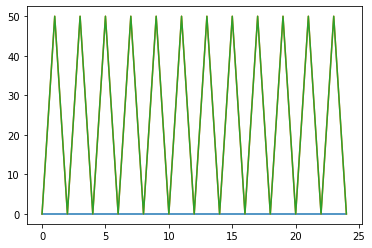

: 

In [4]:
cap = cv2.VideoCapture(kat + "\\" + plik)

if ile < 0:
    ile = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

cv2.namedWindow("Normal Frame")
cv2.namedWindow("Decompressed Frame")

compression_information = np.zeros((3, ile))

for i in range(ile):
    ret, frame = cap.read()
    if wyswietlaj_kaltki:
        cv2.imshow("Normal Frame", frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    if (i % key_frame_counter) == 0:  # pobieranie klatek kluczowych
        key_frame = frame
        cY = frame[:, :, 0]
        cCb = frame[:, :, 2]
        cCr = frame[:, :, 1]
        d_frame = frame
    else:  # kompresja
        cdata,shape = compress(
            frame[:, :, 0],
            frame[:, :, 2],
            frame[:, :, 1],
            key_frame[:, :, 0],
            key_frame[:, :, 2],
            key_frame[:, :, 1],
        )
        cY = cdata.Y
        cCb = cdata.Cb
        cCr = cdata.Cr
        d_frame = decompress(
            cdata, key_frame[:, :, 0], key_frame[:, :, 2], key_frame[:, :, 1], A=frame, shape=shape
        )

    compression_information[0, i] = (frame[:, :, 0].size - cY.size) / frame[
        :, :, 0
    ].size
    compression_information[1, i] = (frame[:, :, 0].size - cCb.size) / frame[
        :, :, 0
    ].size
    compression_information[2, i] = (frame[:, :, 0].size - cCr.size) / frame[
        :, :, 0
    ].size
    # d_frame = cv2.cvtColor(d_frame, cv2.COLOR_YCrCb2BGR)
    if wyswietlaj_kaltki:
        cv2.imshow("Decompressed Frame", cv2.cvtColor(d_frame, cv2.COLOR_YCrCb2BGR))

    if np.any(plot_frames == i):  # rysuj wykresy
        # bardzo słaby i sztuczny przyklad wykrozystania tej opcji
        fig, axs = plt.subplots(1, 3, sharey=True)
        fig.set_size_inches(16, 5)
        axs[0].imshow(frame)
        axs[2].imshow(d_frame)
        diff = frame.astype(float) - d_frame.astype(float)
        print(np.min(diff), np.max(diff))
        axs[1].imshow(diff, vmin=np.min(diff), vmax=np.max(diff))

    if np.any(auto_pause_frames == i):
        cv2.waitKey(-1)  # wait until any key is pressed

    k = cv2.waitKey(1) & 0xFF

    if k == ord("q"):
        break
    elif k == ord("p"):
        cv2.waitKey(-1)  # wait until any key is pressed

plt.figure()
plt.plot(np.arange(0, ile), compression_information[0, :] * 100)
plt.plot(np.arange(0, ile), compression_information[1, :] * 100)
plt.plot(np.arange(0, ile), compression_information[2, :] * 100)
